<a href="https://colab.research.google.com/github/HArsh-ri01/Deep-Learning/blob/main/monocular_depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xy8bbxv8br-2.zip

--2025-03-28 18:05:18--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xy8bbxv8br-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.68.10, 3.5.70.38, 52.218.56.72, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2086064868 (1.9G) [application/zip]
Saving to: ‘xy8bbxv8br-2.zip’

xy8bbxv8br-2.zip    100%[===================>]   1.94G  25.3MB/s    in 86s     

2025-03-28 18:06:45 (23.1 MB/s) - ‘xy8bbxv8br-2.zip’ saved [2086064868/2086064868]



In [ ]:
!pip install h5py


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

zip_file_path = 'xy8bbxv8br-2.zip'
extract_dir = 'depth_images'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)




## Visualization

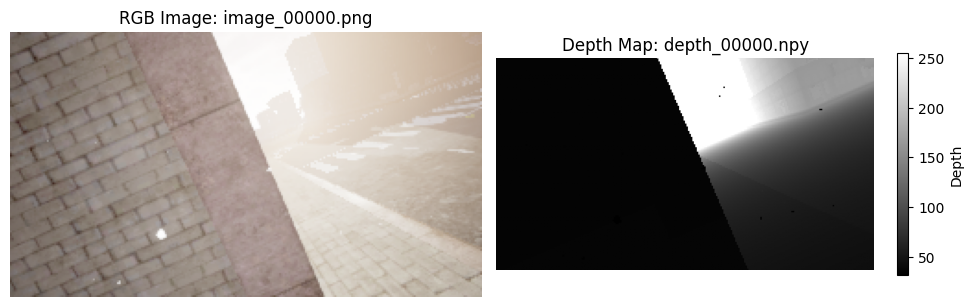

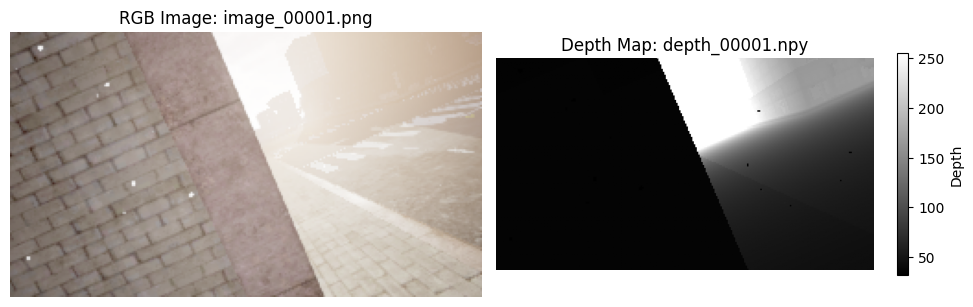

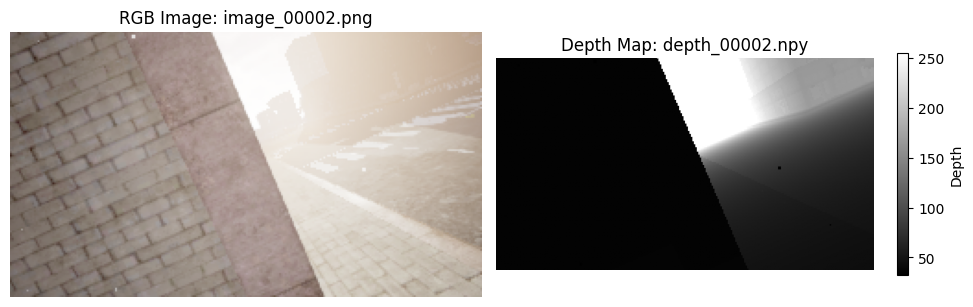

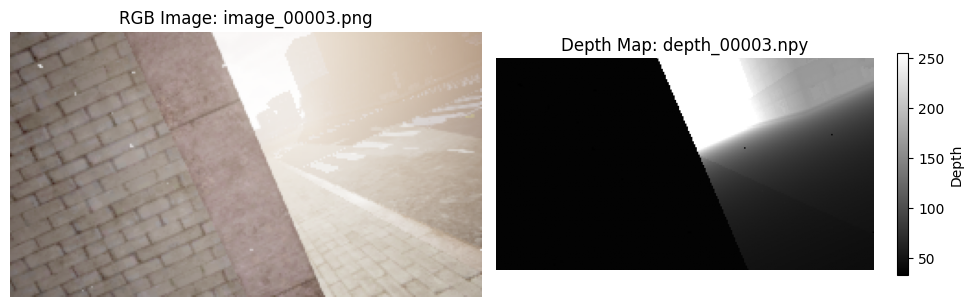

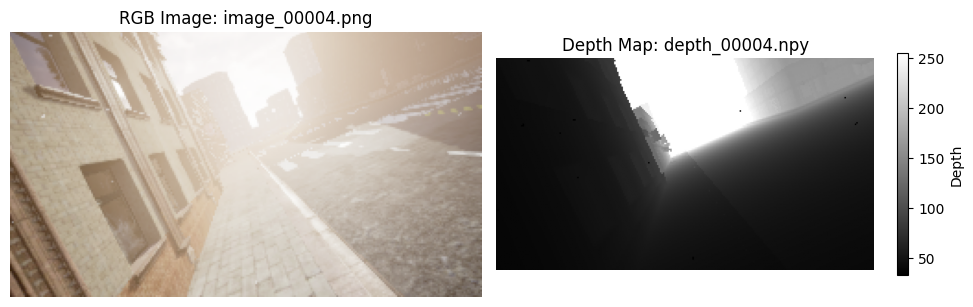

In [ ]:
from PIL import Image

# Define paths
base_path = "depth_images"
depth_folder = os.path.join(base_path, "Monocular Depth Estimation Dataset", "1. Urban", "depth")
rgb_folder   = os.path.join(base_path, "Monocular Depth Estimation Dataset", "1. Urban", "image")

# List and sort all .npy depth files
npy_files = sorted([f for f in os.listdir(depth_folder) if f.endswith(".npy")])

# Visualize first 5 matching pairs
for i, file in enumerate(npy_files[:5]):
    # Extract index from depth filename
    index = file.replace("depth_", "").replace(".npy", "")
    rgb_filename = f"image_{index}.png"

    depth_path = os.path.join(depth_folder, file)
    rgb_path = os.path.join(rgb_folder, rgb_filename)

    # Load depth and RGB image
    depth_map = np.load(depth_path)
    rgb_img = Image.open(rgb_path)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(rgb_img)
    axes[0].set_title(f"RGB Image: {rgb_filename}")
    axes[0].axis('off')

    im = axes[1].imshow(depth_map, cmap='gray')
    axes[1].set_title(f"Depth Map: {file}")
    axes[1].axis('off')

    fig.colorbar(im, ax=axes[1], shrink=0.6, label='Depth')
    plt.tight_layout()
    plt.show()

## Multiscale Neural Network

Epoch 1, Loss: 71.6809
Epoch 2, Loss: 60.1312
Epoch 3, Loss: 56.9932
Epoch 4, Loss: 53.5272
Epoch 5, Loss: 51.1415


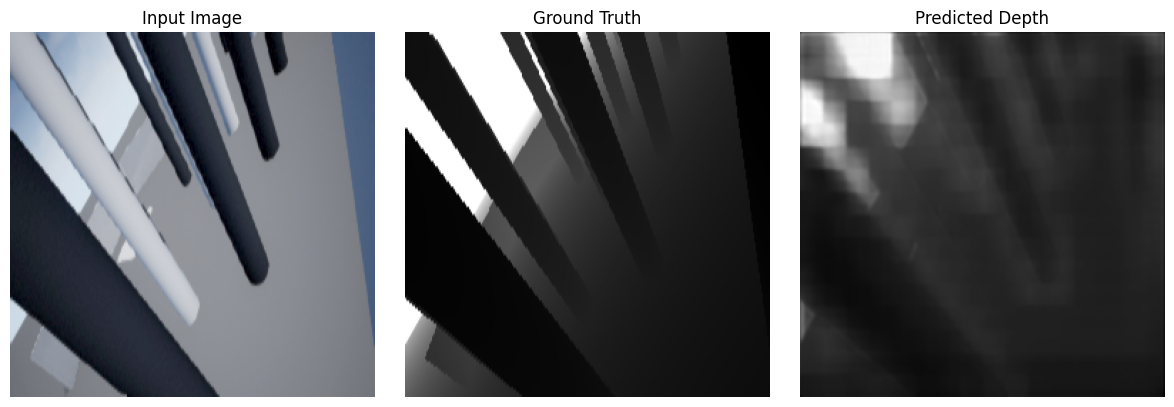

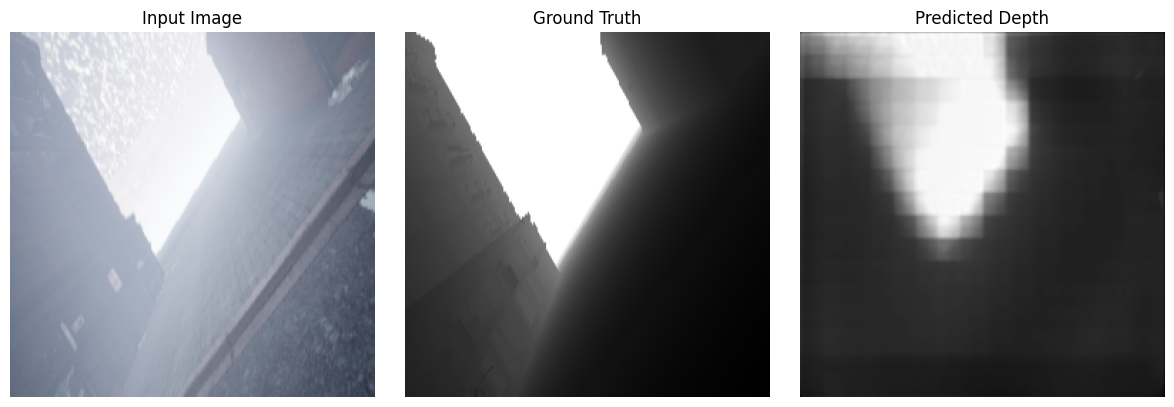

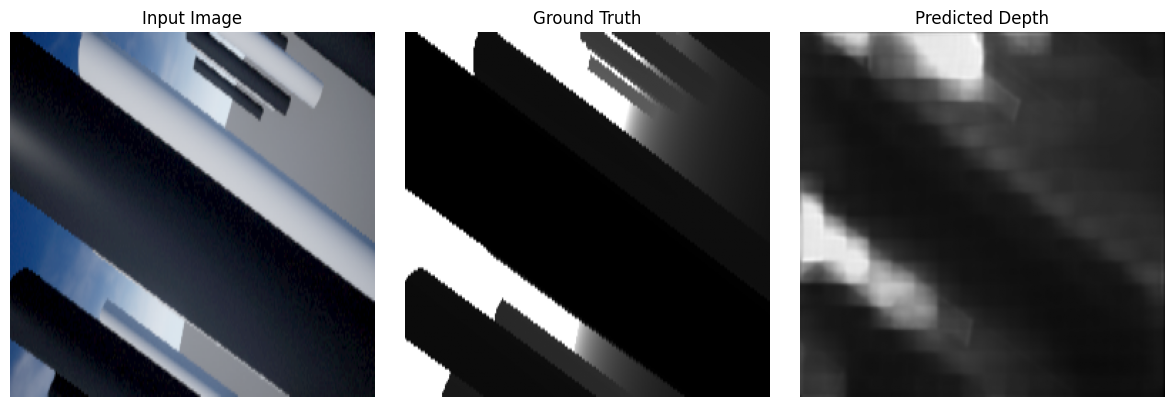

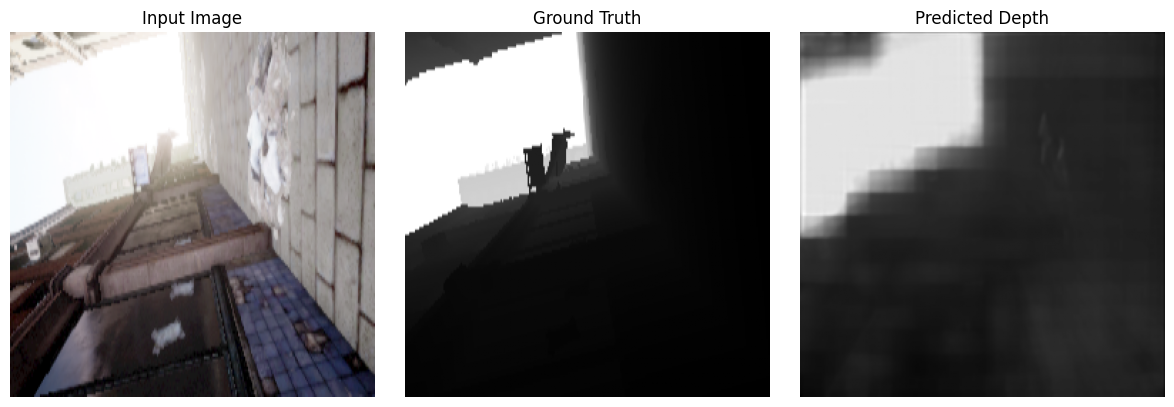

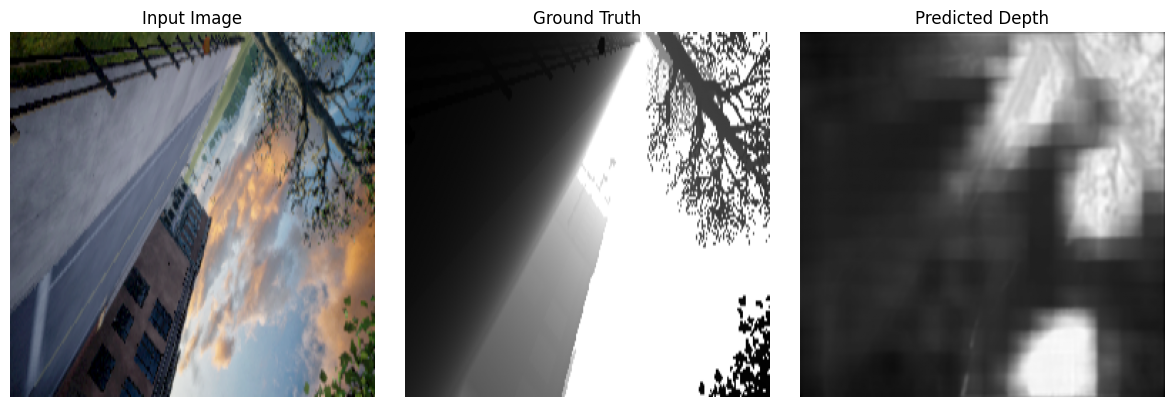

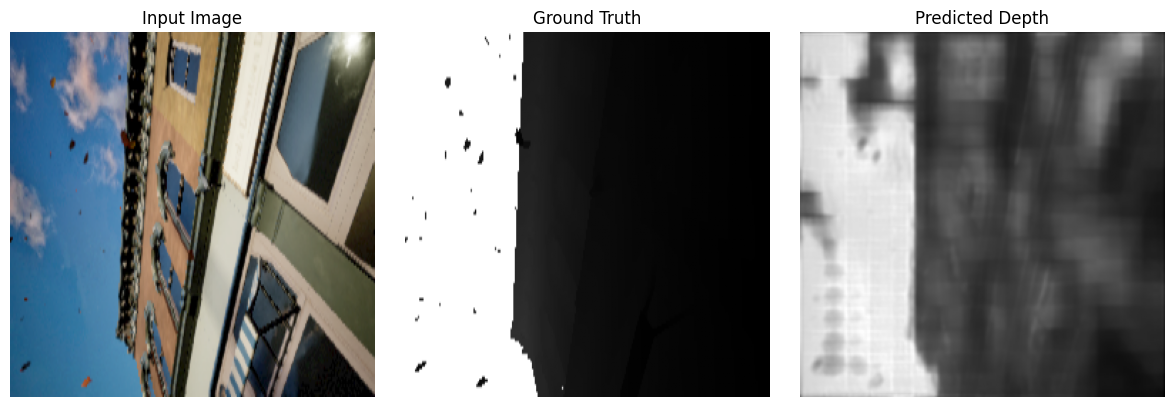

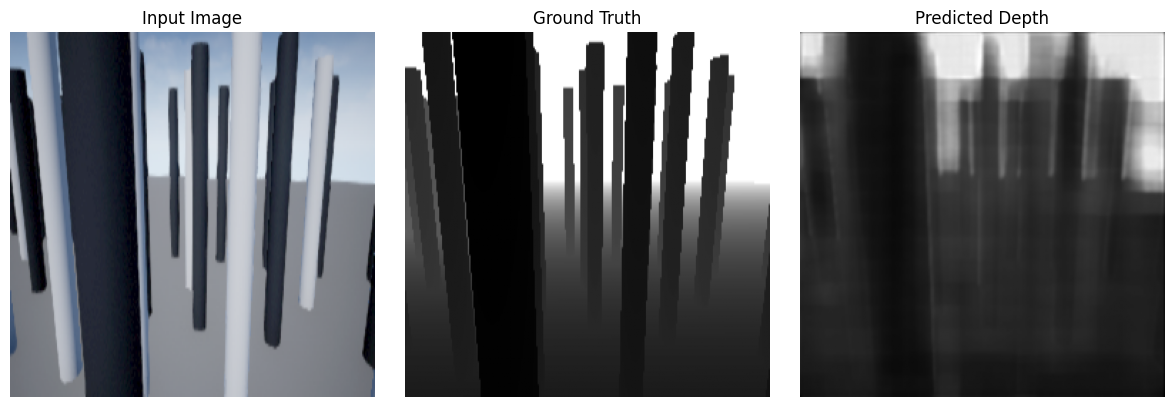

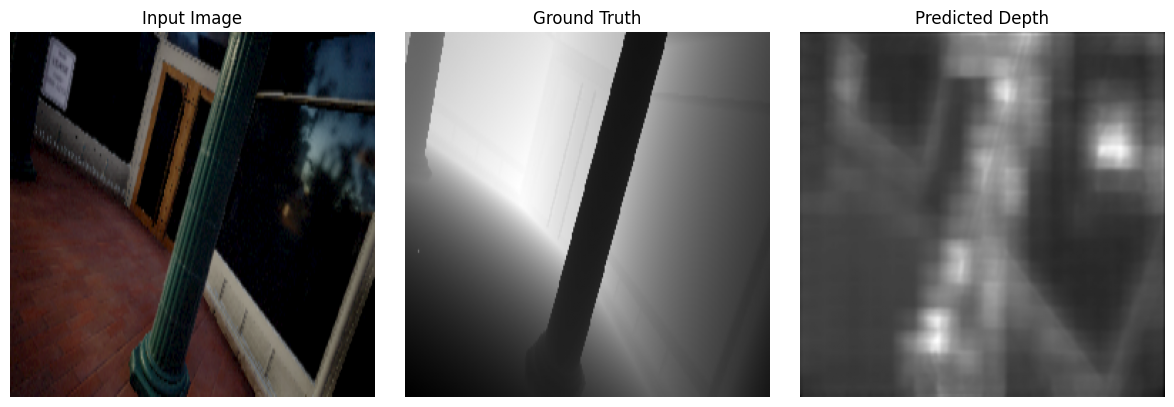

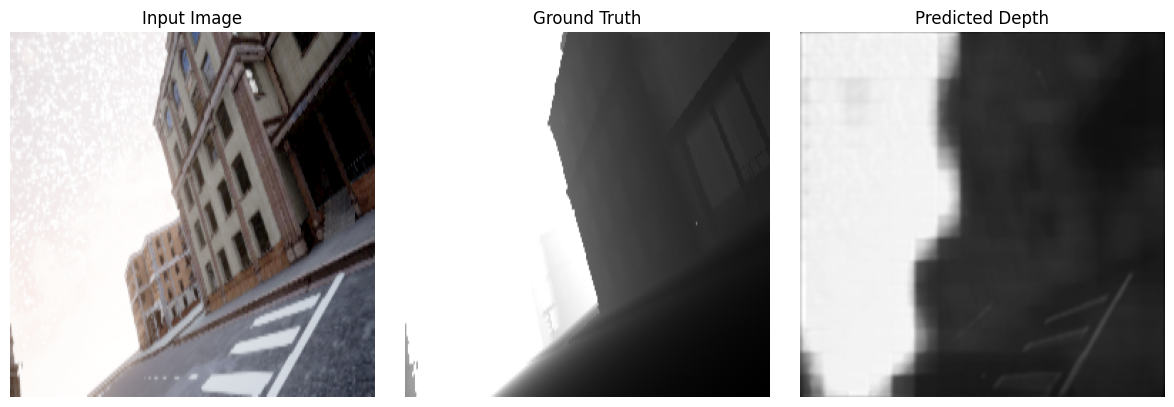

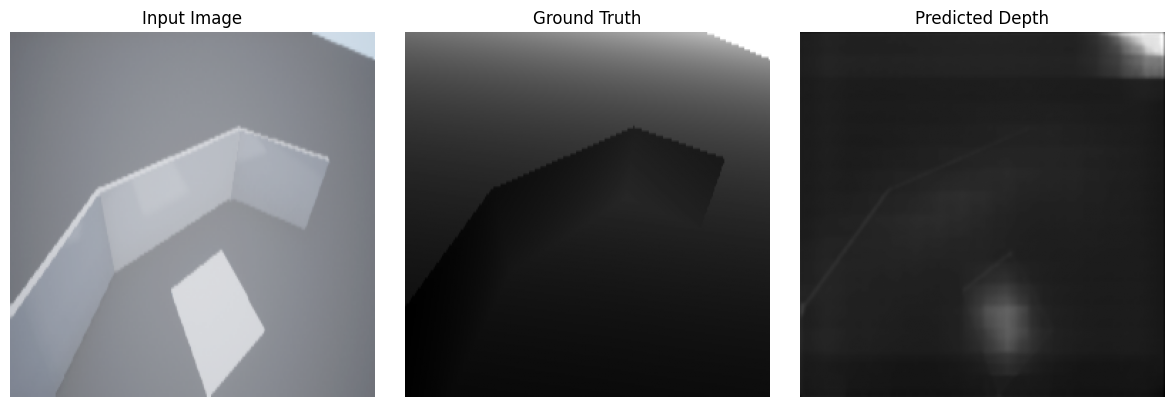

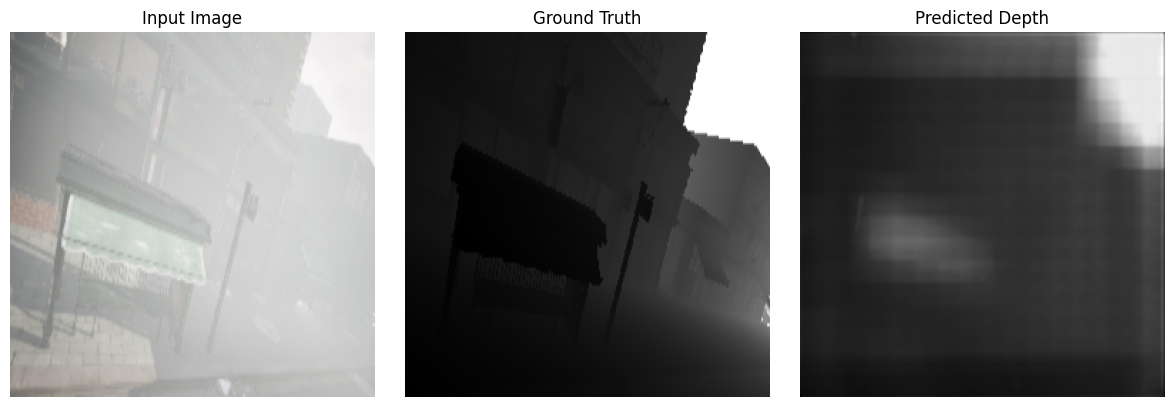

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt

# --------------------- Dataset ---------------------
class MultiScaleDepthDataset(Dataset):
    def __init__(self, base_path, folders, transform=None):
        self.samples = []
        self.transform = transform

        for folder in folders:
            rgb_folder = os.path.join(base_path, folder, "image")
            depth_folder = os.path.join(base_path, folder, "depth")

            depth_files = sorted([f for f in os.listdir(depth_folder) if f.endswith(".npy")])
            for file in depth_files:
                index = file.replace("depth_", "").replace(".npy", "")
                rgb_file = f"image_{index}.png"
                self.samples.append({
                    "rgb": os.path.join(rgb_folder, rgb_file),
                    "depth": os.path.join(depth_folder, file)
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        rgb = Image.open(sample["rgb"]).convert("RGB")
        depth = np.load(sample["depth"]).astype(np.float32)

        if self.transform:
            rgb = self.transform(rgb)
            depth = torch.from_numpy(depth)
            depth = F.interpolate(depth.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        return rgb, depth

# --------------------- Model ---------------------
class CoarseNet(nn.Module):
    def __init__(self):
        super(CoarseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        feat = self.encoder(x)
        depth_coarse = self.decoder(feat)
        return depth_coarse

class FineNet(nn.Module):
    def __init__(self):
        super(FineNet, self).__init__()
        self.rgb_feat = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(33, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, rgb, coarse_depth):
        rgb_feat = self.rgb_feat(rgb)
        upsampled_coarse = F.interpolate(coarse_depth, size=rgb.shape[2:], mode='bilinear', align_corners=False)
        concat = torch.cat((rgb_feat, upsampled_coarse), dim=1)
        refined_depth = self.fuse(concat)
        return refined_depth

class CoarseToFineDepthNet(nn.Module):
    def __init__(self):
        super(CoarseToFineDepthNet, self).__init__()
        self.coarse = CoarseNet()
        self.fine = FineNet()

    def forward(self, rgb):
        coarse_depth = self.coarse(rgb)
        refined_depth = self.fine(rgb, coarse_depth)
        return refined_depth, coarse_depth

# --------------------- Loss ---------------------
def depth_loss(refined, coarse, gt):
    coarse_up = F.interpolate(coarse, size=gt.shape[-2:], mode='bilinear', align_corners=False)
    loss_coarse = F.l1_loss(coarse_up, gt)
    loss_refined = F.l1_loss(refined, gt)
    return loss_refined + 0.5 * loss_coarse

# --------------------- Training Script ---------------------
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    base_path = "depth_images/Monocular Depth Estimation Dataset"
    folders = ["1. Urban", "2. Downtown", "3. Pillar World"]

    full_dataset = MultiScaleDepthDataset(
        base_path=base_path,
        folders=folders,
        transform=T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])
    )

    test_size = int(0.1 * len(full_dataset))
    train_size = len(full_dataset) - test_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = CoarseToFineDepthNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(5):
        model.train()
        total_loss = 0
        for rgb, depth in train_loader:
            rgb, depth = rgb.to(device), depth.to(device)
            refined, coarse = model(rgb)
            loss = depth_loss(refined, coarse, depth)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # --------------------- Evaluation ---------------------
    model.eval()
    with torch.no_grad():
        for i, (rgb, depth) in enumerate(test_loader):
            rgb, depth = rgb.to(device), depth.to(device)
            pred, _ = model(rgb)

            # Move tensors to CPU for visualization
            rgb_img = rgb.squeeze(0).permute(1, 2, 0).cpu().numpy()
            gt_depth = depth.squeeze().cpu().numpy()
            pred_depth = pred.squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(rgb_img)
            axs[0].set_title("Input Image")
            axs[0].axis('off')

            axs[1].imshow(gt_depth, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(pred_depth, cmap='gray')
            axs[2].set_title("Predicted Depth")
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

            if i == 10:
                break


## UNET based depth estimation

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-9104b044a59b>:101: UserWarning: Using a target size (torch.Size([8, 1, 1, 128, 128])) that is different to the input size (torch.Size([8, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(pred, gt)


Epoch 1, Loss: 54.4210


<ipython-input-4-9104b044a59b>:101: UserWarning: Using a target size (torch.Size([5, 1, 1, 128, 128])) that is different to the input size (torch.Size([5, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(pred, gt)


Epoch 2, Loss: 52.6327
Epoch 3, Loss: 52.3687


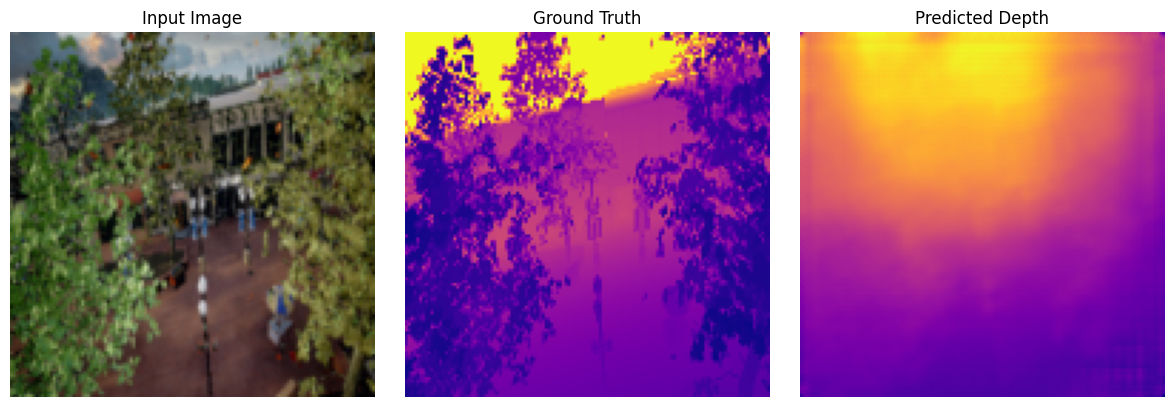

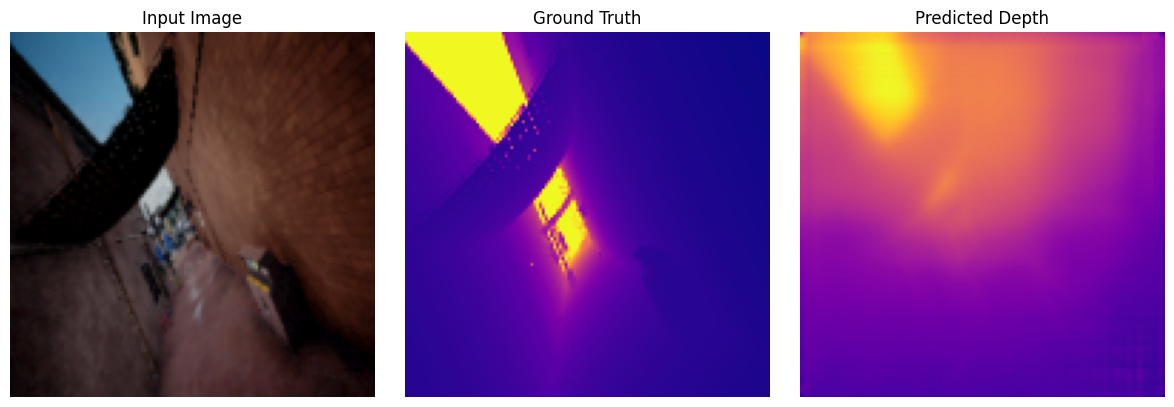

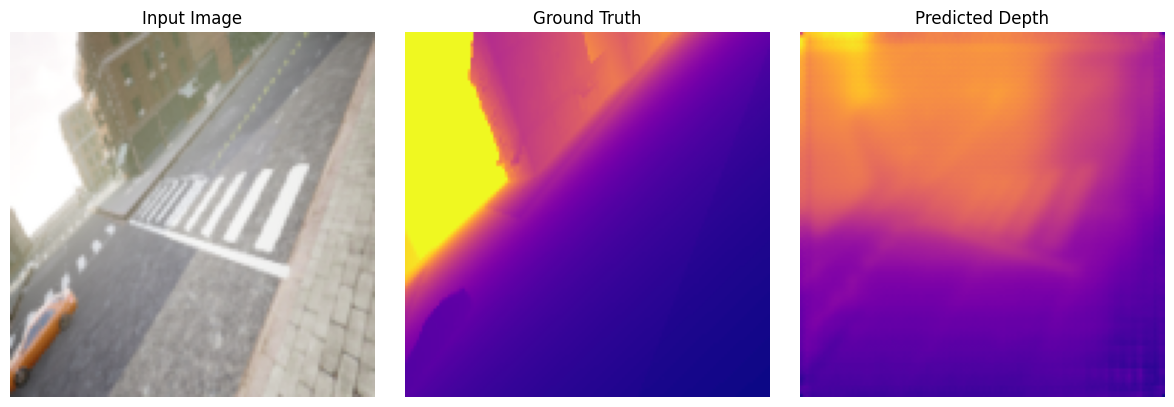

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt

# --------------------- Dataset ---------------------
class MultiScaleDepthDataset(Dataset):
    def __init__(self, base_path, folders, transform=None):
        self.samples = []
        self.transform = transform

        for folder in folders:
            rgb_folder = os.path.join(base_path, folder, "image")
            depth_folder = os.path.join(base_path, folder, "depth")

            depth_files = sorted([f for f in os.listdir(depth_folder) if f.endswith(".npy")])
            for file in depth_files:
                index = file.replace("depth_", "").replace(".npy", "")
                rgb_file = f"image_{index}.png"
                self.samples.append({
                    "rgb": os.path.join(rgb_folder, rgb_file),
                    "depth": os.path.join(depth_folder, file)
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        rgb = Image.open(sample["rgb"]).convert("RGB")
        depth = np.load(sample["depth"]).astype(np.float32)

        if self.transform:
            rgb = self.transform(rgb)
            depth = torch.from_numpy(depth)
            depth = F.interpolate(depth.unsqueeze(0).unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)

        return rgb, depth

# --------------------- U-Net ---------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        bn = self.bottleneck(self.pool4(d4))

        up4 = self.up_conv4(torch.cat([self.up4(bn), d4], dim=1))
        up3 = self.up_conv3(torch.cat([self.up3(up4), d3], dim=1))
        up2 = self.up_conv2(torch.cat([self.up2(up3), d2], dim=1))
        up1 = self.up_conv1(torch.cat([self.up1(up2), d1], dim=1))

        return self.final(up1)

# --------------------- Loss Function ---------------------
def depth_loss(pred, gt):
    return F.l1_loss(pred, gt)

# --------------------- Training Script ---------------------
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base_path = "depth_images/Monocular Depth Estimation Dataset"
    folders = ["1. Urban", "2. Downtown", "3. Pillar World"]

    full_dataset = MultiScaleDepthDataset(
        base_path=base_path,
        folders=folders,
        transform=T.Compose([
            T.Resize((128, 128)),
            T.ToTensor()
        ])
    )

    test_size = int(0.1 * len(full_dataset))
    train_size = len(full_dataset) - test_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = UNet(in_channels=3, out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(3):
        model.train()
        total_loss = 0
        for rgb, depth in train_loader:
            rgb, depth = rgb.to(device, non_blocking=True), depth.to(device, non_blocking=True).unsqueeze(1)
            pred = model(rgb)
            loss = depth_loss(pred, depth)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # --------------------- Evaluation ---------------------
    model.eval()
    with torch.no_grad():
        for i, (rgb, depth) in enumerate(test_loader):
            rgb, depth = rgb.to(device), depth.to(device).unsqueeze(1)
            pred = model(rgb)

            rgb_img = rgb.squeeze(0).permute(1, 2, 0).cpu().numpy()
            gt_depth = depth.squeeze().cpu().numpy()
            pred_depth = pred.squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(rgb_img)
            axs[0].set_title("Input Image")
            axs[0].axis('off')

            axs[1].imshow(gt_depth, cmap='plasma')
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(pred_depth, cmap='plasma')
            axs[2].set_title("Predicted Depth")
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

            if i == 2:
                break
